In [1]:
# All required python standard libraries
import os
import time

In [2]:
# All torch related imports 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from torch import nn, optim
import torchvision

In [3]:
# using cv2 to read an image
import cv2

In [4]:
# All sci-kit related imports 
import pandas as pd
import numpy as np

In [5]:
from tqdm.notebook import tqdm as tq

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
IMAGE_DIMS = 28

In [8]:
def accuracy_finder(predictions , labels):
    values, max_indices = torch.max(predictions, dim=1)
    accuracy = ( max_indices == labels ).sum()
    return accuracy/max_indices.size()[0]

In [9]:
def csv_preprocessor(base_dir:str, directory:str):
    return os.path.join(base_dir,directory).replace("\\","/")

In [10]:
def return_all_image_list_from_processed_csv(csv_file):
    ### This returns the entire list full of images to be loaded into cpu
    ###
    ###
    ALL_IMAGES = []
    start = time.time()
    for i, items in tq(enumerate(csv_file)):
        image = cv2.imread(items, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(image,(IMAGE_DIMS,IMAGE_DIMS))
        ALL_IMAGES.append(resized)
    
    print("Tt took us approximately {} seconds".format(time.time()-start))  
    return ALL_IMAGES

In [11]:
def get_one_hot_encoded_labels(input_data_frame):
    input_data_frame.labels = input_data_frame.labels.map(lambda x: x-1)
    # return pd.get_dummies(input_data_frame.labels, prefix='labels').to_numpy()
    return input_data_frame.labels

In [12]:
# pytorch device configurations 
BATCH_SIZE = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
DEVICE

device(type='cuda')

In [14]:
train_csv_directory = os.path.join(os.getcwd(),'guides\\isolated-dataset-csv\\IsolatedTrain.csv')

In [15]:
DATASET_DATAFRAME = pd.read_csv(train_csv_directory, usecols=["labels","directory"])
DATASET_DATAFRAME.labels = DATASET_DATAFRAME.labels - 1
DATASET_DATAFRAME

,labels,directory
0,0,dataset\IsolatedTrain\1\bcc000000.bmp
1,0,dataset\IsolatedTrain\1\bcc000133.bmp
2,0,dataset\IsolatedTrain\1\bcc000134.bmp
3,0,dataset\IsolatedTrain\1\bcc000135.bmp
4,0,dataset\IsolatedTrain\1\bcc000136.bmp
...,...,...
34434,170,dataset\IsolatedTrain\171\bcc000067.bmp
34435,170,dataset\IsolatedTrain\171\bcc000068.bmp
34436,170,dataset\IsolatedTrain\171\bcc000069.bmp
34437,170,dataset\IsolatedTrain\171\bcc000071.bmp


In [16]:
X_TRAIN_CSV, X_VAL_CSV,Y_TRAIN, Y_VAL = train_test_split(DATASET_DATAFRAME.directory, DATASET_DATAFRAME.labels, test_size=0.10, stratify=DATASET_DATAFRAME.labels)

In [17]:
print(len(X_TRAIN_CSV),len(X_VAL_CSV),len(Y_TRAIN), len(Y_VAL))

30995 3444 30995 3444


In [18]:
DATA_NORMALIZER = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),transforms.Resize((IMAGE_DIMS,IMAGE_DIMS))])

In [19]:
class LeanIsolatedCharacterDataset(Dataset):
    def __init__(self, image_dirs_data_frame, labels,  transforms=None):
          
        ### labels
        self.labels = labels.to_numpy()
        
        ### loading dataset into memory
        self.dataset_csv = image_dirs_data_frame.map(lambda x: csv_preprocessor(base_dir=str(os.getcwd()), directory=str(x)))
        self.ALL_IMAGES = return_all_image_list_from_processed_csv(csv_file=self.dataset_csv)
        
        ### transformations to apply on images
        self.transforms = transforms
        
    def __getitem__(self, index):
        # convert labels to tensor 
        label = torch.tensor(self.labels[index])
        # load single image from list of all preloaded images
        image = self.ALL_IMAGES[index]
        if self.transforms:
            ## apply transforms 
            image = self.transforms(image)    
            image = image.float()
        label = label.long()
        return image, label 
    
    def __len__(self):
        return len(self.ALL_IMAGES)

In [20]:
TRAINING_DATASET = LeanIsolatedCharacterDataset(image_dirs_data_frame=X_TRAIN_CSV, labels=Y_TRAIN, transforms=DATA_NORMALIZER)


Tt took us approximately 4.40193247795105 seconds


In [21]:
len(TRAINING_DATASET)

30995

In [22]:
VALIDATION_DATASET = LeanIsolatedCharacterDataset(image_dirs_data_frame=X_VAL_CSV, labels=Y_VAL, transforms=DATA_NORMALIZER)


Tt took us approximately 0.5440163612365723 seconds


In [23]:
len(VALIDATION_DATASET)

3444

In [24]:
TRAINING_LOADER = DataLoader(dataset=TRAINING_DATASET,batch_size=BATCH_SIZE,shuffle=True)
VALIDATION_LOADER = DataLoader(dataset=VALIDATION_DATASET,batch_size=BATCH_SIZE,shuffle=True)

In [25]:
class block(nn.Module):
    def __init__(self, in_channels, intermediate_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1,)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, padding=0,)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride
    
    #Identity block
    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        #x = self.relu(x) #custom 

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [26]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels change
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, intermediate_channels * 4, kernel_size=1, stride=stride,),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [27]:
def ResNet50(img_channel=3, num_classes=171):
    return ResNet(block, [2, 3, 5, 2], img_channel, num_classes)
net = ResNet50()

In [28]:
optimizer =  optim.Adam(net.parameters(), lr=0.07) # learning rate 
# defining the loss function
criterion =  nn.CrossEntropyLoss() # reduction='none'
net = net.to(DEVICE)
criterion = criterion.to(DEVICE)

In [29]:
from tqdm import tqdm 

In [30]:
def validate(ValidationLoader):
    total_val_accuracy = 0
    total_val_loss = 0 
    
    for i, data in enumerate(ValidationLoader, 0):
       # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_val_loss += loss
        val_accuracy = accuracy_finder(predictions=outputs, labels=labels)
        total_val_accuracy = total_val_accuracy + val_accuracy
        
    return (total_val_loss/len(ValidationLoader), total_val_accuracy/len(ValidationLoader))

In [31]:
def training(epochs:int = 0, TRAINING_LOADER = TRAINING_LOADER , VALIDATION_LOADER = VALIDATION_LOADER, OPTIM_MODEL_NAME="" ):
    all_training_losses = []
    all_training_accuracy = []
    
    all_validation_losses = []
    all_validation_accuracy = []
    
    minimum_validation_loss = torch.tensor(999999999).to(DEVICE)
    minimum_validation_epoch_number = -1
    
    
    for epoch in tq(range(epochs)):
        total_epoch_loss = 0
        total_accuracy_epoch = 0
        for i, data in tqdm(enumerate(TRAINING_LOADER, 0)): 
            
            image = 0
            label = 0
            
            image,label = data
            
            optimizer.zero_grad(set_to_none=True)
            
            label = label.to(DEVICE)
            image = image.to(DEVICE)
            output = net(image)
            
            
            
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                total_epoch_loss += loss
                batches_training_accuracy = accuracy_finder(predictions=output, labels=label)
                total_accuracy_epoch = total_accuracy_epoch  + batches_training_accuracy   
            
            if i % 100 == 0 and i != 0: 
                print("Batch : {}/{}".format(i, len(TRAINING_LOADER)))
           
        # total epoch loss 
        total_epoch_loss = total_epoch_loss / len(TRAINING_LOADER)
        # total epoch accuracy 
        total_accuracy_epoch = total_accuracy_epoch /len(TRAINING_LOADER)
        
        optimizer.zero_grad(set_to_none=True)
        
        inputs = 0
        image = 0
        output = 0
        
        with torch.no_grad():
             validation_loss, validation_accuracy = validate(ValidationLoader= VALIDATION_LOADER )
        
        all_validation_losses.append(validation_loss)
        all_validation_accuracy.append(validation_accuracy)
        
        if minimum_validation_loss > validation_loss:
            minimum_validation_loss = validation_loss
            minimum_validation_epoch_number = epoch
            print("Saved model at epoch {}".format(epoch+1))
            PATH = OPTIM_MODEL_NAME
            # saving model
            torch.save(net.state_dict(), PATH)
            
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}, acc = {:.8f}, val_loss = {:.8f} , val_acc = {:.8f}".format(epoch + 1, epochs, total_epoch_loss, total_accuracy_epoch, validation_loss, validation_accuracy ))
        all_training_losses.append(total_epoch_loss)
        all_training_accuracy.append(total_accuracy_epoch)
        
    print("Training completed")
    return all_training_accuracy, all_training_losses,all_validation_accuracy,all_validation_losses,minimum_validation_epoch_number, minimum_validation_loss

In [32]:
PATH = "./models"
MODEL_NAME = "custom_resnet_50"
MODEL_NAME_PATH = "{}/{}_minimum_validation_loss.pth".format(PATH,MODEL_NAME)
OPTIM_MODEL_NAME_PATH = "{}/{}_minimum_validation_loss.pth".format(PATH,MODEL_NAME)

In [33]:
t_acc, t_loss, v_acc, v_loss, min_val_loss, min_val_loss_epoch = training(100, TRAINING_LOADER = TRAINING_LOADER , VALIDATION_LOADER = VALIDATION_LOADER, OPTIM_MODEL_NAME=OPTIM_MODEL_NAME_PATH)

101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:38,  1.24it/s]


Saved model at epoch 1
epoch : 1/100, loss = 9.55861282, acc = 0.00992572, val_loss = 5.07272339 , val_acc = 0.01233451


101it [01:23,  1.15it/s]

Batch : 100/122


122it [01:42,  1.20it/s]


Saved model at epoch 2
epoch : 2/100, loss = 5.02205801, acc = 0.01418417, val_loss = 4.98967171 , val_acc = 0.01596175

0it [00:00, ?it/s]

101it [01:24,  1.26it/s]

Batch : 100/122


122it [01:41,  1.20it/s]
0it [00:00, ?it/s]

Saved model at epoch 3
epoch : 3/100, loss = 4.90004969, acc = 0.02282915, val_loss = 4.81287718 , val_acc = 0.02829626


101it [01:21,  1.25it/s]

Batch : 100/122


122it [01:37,  1.25it/s]


Saved model at epoch 4
epoch : 4/100, loss = 4.73553753, acc = 0.03241783, val_loss = 4.69162560 , val_acc = 0.03024939


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]


Saved model at epoch 5


0it [00:00, ?it/s]

epoch : 5/100, loss = 4.53773403, acc = 0.04187844, val_loss = 4.39186096 , val_acc = 0.04710592


101it [01:19,  1.26it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 6
epoch : 6/100, loss = 4.13982248, acc = 0.06942946, val_loss = 3.96522832 , val_acc = 0.08155018


101it [01:20,  1.21it/s]

Batch : 100/122


122it [01:37,  1.26it/s]


Saved model at epoch 7


0it [00:00, ?it/s]

epoch : 7/100, loss = 3.77877522, acc = 0.09882408, val_loss = 3.71889830 , val_acc = 0.10565156


101it [01:20,  1.22it/s]

Batch : 100/122


122it [01:37,  1.25it/s]
0it [00:00, ?it/s]

Saved model at epoch 8
epoch : 8/100, loss = 3.44099975, acc = 0.14116761, val_loss = 3.43660069 , val_acc = 0.14361723


101it [01:22,  1.19it/s]

Batch : 100/122


122it [01:40,  1.21it/s]


Saved model at epoch 9
epoch : 9/100, loss = 3.17454076, acc = 0.17480047, val_loss = 3.28770351 , val_acc = 0.15912679


101it [01:24,  1.19it/s]

Batch : 100/122


122it [01:41,  1.20it/s]


Saved model at epoch 10
epoch : 10/100, loss = 3.02648020, acc = 0.19745435, val_loss = 2.97228098 , val_acc = 0.21020630


101it [01:22,  1.18it/s]

Batch : 100/122


122it [01:39,  1.22it/s]


Saved model at epoch 11
epoch : 11/100, loss = 2.72083926, acc = 0.25269964, val_loss = 2.64964437 , val_acc = 0.27316812


101it [01:22,  1.25it/s]

Batch : 100/122


122it [01:39,  1.23it/s]


Saved model at epoch 12
epoch : 12/100, loss = 2.50187826, acc = 0.29408431, val_loss = 2.50787783 , val_acc = 0.31063348


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]


Saved model at epoch 13
epoch : 13/100, loss = 2.26304674, acc = 0.34627438, val_loss = 2.42287493 , val_acc = 0.33646670


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 14/100, loss = 2.10434389, acc = 0.39481264, val_loss = 2.46640849 , val_acc = 0.36168414


101it [01:20,  1.21it/s]

Batch : 100/122


122it [01:37,  1.25it/s]


Saved model at epoch 15
epoch : 15/100, loss = 1.98058236, acc = 0.43418184, val_loss = 2.07559085 , val_acc = 0.43323779


101it [01:23,  1.25it/s]

Batch : 100/122


122it [01:39,  1.22it/s]
0it [00:00, ?it/s]

Saved model at epoch 16
epoch : 16/100, loss = 1.68797708, acc = 0.51368028, val_loss = 1.94602334 , val_acc = 0.46220756


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 17
epoch : 17/100, loss = 1.55971611, acc = 0.54337651, val_loss = 1.80262220 , val_acc = 0.50602293


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]


Saved model at epoch 18
epoch : 18/100, loss = 1.40915918, acc = 0.58698565, val_loss = 1.66290247 , val_acc = 0.56430882


101it [01:21,  1.20it/s]

Batch : 100/122


122it [01:39,  1.23it/s]
0it [00:00, ?it/s]

epoch : 19/100, loss = 1.23877585, acc = 0.62974882, val_loss = 1.72251582 , val_acc = 0.56218255


101it [01:23,  1.20it/s]

Batch : 100/122


122it [01:40,  1.21it/s]


Saved model at epoch 20
epoch : 20/100, loss = 1.17383015, acc = 0.65030295, val_loss = 1.47204041 , val_acc = 0.61323321


101it [01:23,  1.23it/s]

Batch : 100/122


122it [01:40,  1.22it/s]
0it [00:00, ?it/s]

epoch : 21/100, loss = 1.04731953, acc = 0.68798530, val_loss = 1.49498439 , val_acc = 0.62057424


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 22
epoch : 22/100, loss = 0.99366122, acc = 0.70444447, val_loss = 1.44622219 , val_acc = 0.63004154


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 23/100, loss = 0.92508286, acc = 0.72448802, val_loss = 1.51852465 , val_acc = 0.63211983


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 24
epoch : 24/100, loss = 0.96305066, acc = 0.71521443, val_loss = 1.28365779 , val_acc = 0.67164409


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 25/100, loss = 0.76244867, acc = 0.76934415, val_loss = 1.40226126 , val_acc = 0.66053146


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 26/100, loss = 0.74596804, acc = 0.77211624, val_loss = 1.44895065 , val_acc = 0.65683693


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 27
epoch : 27/100, loss = 0.90952629, acc = 0.73682857, val_loss = 1.25762296 , val_acc = 0.68172723


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 28/100, loss = 0.67165887, acc = 0.79627168, val_loss = 1.42668474 , val_acc = 0.67279869


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]


Saved model at epoch 29
epoch : 29/100, loss = 0.67911202, acc = 0.79655814, val_loss = 1.24584198 , val_acc = 0.70808965


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 30/100, loss = 0.53933072, acc = 0.83432811, val_loss = 1.34980118 , val_acc = 0.69586098


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 31/100, loss = 0.69823176, acc = 0.79338831, val_loss = 1.38609815 , val_acc = 0.70640588


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 32/100, loss = 0.52123463, acc = 0.84117836, val_loss = 1.37837851 , val_acc = 0.72247344


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]


Saved model at epoch 33
epoch : 33/100, loss = 0.62290567, acc = 0.81749821, val_loss = 1.20375192 , val_acc = 0.72834247


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 34/100, loss = 0.56162858, acc = 0.83144474, val_loss = 1.21944404 , val_acc = 0.73577970


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 35/100, loss = 0.52968979, acc = 0.84159291, val_loss = 1.32801938 , val_acc = 0.72903520


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 36/100, loss = 0.49424747, acc = 0.85210848, val_loss = 1.23586321 , val_acc = 0.74235111


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 37/100, loss = 0.43677318, acc = 0.86686897, val_loss = 1.26775312 , val_acc = 0.74409258


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 38/100, loss = 0.45551354, acc = 0.86287171, val_loss = 1.36728561 , val_acc = 0.72749579


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 39/100, loss = 0.55051976, acc = 0.84197879, val_loss = 1.29535151 , val_acc = 0.73549110


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 40/100, loss = 0.46057472, acc = 0.86020911, val_loss = 1.27513731 , val_acc = 0.75323278


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 41/100, loss = 0.29651272, acc = 0.91298056, val_loss = 1.65048480 , val_acc = 0.72593713


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 42/100, loss = 0.79479361, acc = 0.78468102, val_loss = 1.30845487 , val_acc = 0.72990113


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 43
epoch : 43/100, loss = 0.41710541, acc = 0.87311256, val_loss = 1.17627382 , val_acc = 0.76282525


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 44/100, loss = 0.25432065, acc = 0.92006838, val_loss = 1.33802450 , val_acc = 0.75911146


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 45/100, loss = 0.38253385, acc = 0.88425499, val_loss = 1.23787403 , val_acc = 0.76692396


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 46/100, loss = 0.33607224, acc = 0.90007544, val_loss = 1.24345469 , val_acc = 0.76778978


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 47/100, loss = 0.35524988, acc = 0.89533502, val_loss = 1.38899982 , val_acc = 0.76590407


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 48/100, loss = 0.47139558, acc = 0.86757338, val_loss = 1.24117947 , val_acc = 0.77388012


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 49/100, loss = 0.29517695, acc = 0.91233683, val_loss = 1.32971120 , val_acc = 0.76473987


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 50/100, loss = 0.41355854, acc = 0.87649131, val_loss = 1.18397331 , val_acc = 0.78617615


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 51/100, loss = 0.27284849, acc = 0.91680253, val_loss = 1.23997235 , val_acc = 0.78014356


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 52/100, loss = 0.29146311, acc = 0.91323334, val_loss = 1.22378433 , val_acc = 0.78009546


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:37,  1.25it/s]
0it [00:00, ?it/s]

epoch : 53/100, loss = 0.26894733, acc = 0.91847086, val_loss = 1.35807014 , val_acc = 0.76763588


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 54/100, loss = 0.47597870, acc = 0.87007248, val_loss = 1.26623762 , val_acc = 0.77091676


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 55/100, loss = 0.40636045, acc = 0.88683498, val_loss = 1.21380126 , val_acc = 0.77260047


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 56
epoch : 56/100, loss = 0.45651942, acc = 0.87234414, val_loss = 1.10739350 , val_acc = 0.79950166


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 57/100, loss = 0.18975641, acc = 0.94140959, val_loss = 1.14378822 , val_acc = 0.80068511


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 58/100, loss = 0.21956261, acc = 0.93454242, val_loss = 1.21430063 , val_acc = 0.78801382


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 59/100, loss = 0.27646205, acc = 0.91944325, val_loss = 1.32492232 , val_acc = 0.78639740


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 60/100, loss = 0.37528473, acc = 0.89600575, val_loss = 1.21100485 , val_acc = 0.79878008


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 61/100, loss = 0.21868335, acc = 0.93776119, val_loss = 1.69634771 , val_acc = 0.74079245


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

Saved model at epoch 62
epoch : 62/100, loss = 1.07105315, acc = 0.73942035, val_loss = 1.08243871 , val_acc = 0.76426846


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 63/100, loss = 0.35840181, acc = 0.89419919, val_loss = 1.14359331 , val_acc = 0.78679192


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 64/100, loss = 0.29117960, acc = 0.91466236, val_loss = 1.30060136 , val_acc = 0.77991265


101it [01:20,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 65/100, loss = 0.33381209, acc = 0.90391600, val_loss = 1.14500082 , val_acc = 0.80169529


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 66/100, loss = 0.22944611, acc = 0.93053842, val_loss = 1.23900318 , val_acc = 0.79743308


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 67/100, loss = 0.18334787, acc = 0.94393903, val_loss = 1.32499981 , val_acc = 0.79039991


101it [01:19,  1.26it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 68/100, loss = 0.25828713, acc = 0.92516100, val_loss = 1.24529982 , val_acc = 0.79978067


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 69/100, loss = 0.18275967, acc = 0.94691676, val_loss = 1.42261875 , val_acc = 0.77824819


101it [01:19,  1.26it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 70/100, loss = 0.49055120, acc = 0.87489206, val_loss = 1.26104784 , val_acc = 0.78929347


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 71/100, loss = 0.29631075, acc = 0.91667277, val_loss = 1.13763189 , val_acc = 0.80861300


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 72/100, loss = 0.11107956, acc = 0.96580762, val_loss = 1.24624860 , val_acc = 0.80881512


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 73/100, loss = 0.24123175, acc = 0.93303418, val_loss = 1.23376083 , val_acc = 0.80776632


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 74/100, loss = 0.10147867, acc = 0.96992111, val_loss = 1.29507804 , val_acc = 0.80424494


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 75/100, loss = 0.25815243, acc = 0.92644346, val_loss = 1.30921066 , val_acc = 0.79219908


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 76/100, loss = 0.24196783, acc = 0.93036151, val_loss = 1.25847292 , val_acc = 0.80889201


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 77/100, loss = 0.14987695, acc = 0.95611948, val_loss = 1.28199887 , val_acc = 0.80782408


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 78/100, loss = 0.23142022, acc = 0.93478513, val_loss = 1.30361044 , val_acc = 0.79905909


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 79/100, loss = 0.34235275, acc = 0.90649259, val_loss = 1.31345260 , val_acc = 0.80129123


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 80/100, loss = 0.25934109, acc = 0.92762643, val_loss = 1.27170706 , val_acc = 0.80111802


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 81/100, loss = 0.23697931, acc = 0.93457109, val_loss = 1.25846541 , val_acc = 0.81046033


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 82/100, loss = 0.10699972, acc = 0.96865559, val_loss = 1.33389652 , val_acc = 0.81285602


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 83/100, loss = 0.22592996, acc = 0.93614334, val_loss = 1.41497624 , val_acc = 0.79431576


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 84/100, loss = 0.20945781, acc = 0.93966371, val_loss = 1.43779492 , val_acc = 0.79419070


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 85/100, loss = 0.20467000, acc = 0.94243753, val_loss = 1.50680673 , val_acc = 0.79308426


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 86/100, loss = 0.30750129, acc = 0.92245805, val_loss = 1.39768183 , val_acc = 0.79029405


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 87/100, loss = 0.31946495, acc = 0.91387200, val_loss = 1.08923900 , val_acc = 0.81814778


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 88/100, loss = 0.09409644, acc = 0.97200066, val_loss = 1.20495152 , val_acc = 0.81992763


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 89/100, loss = 0.13079058, acc = 0.96489257, val_loss = 1.29450369 , val_acc = 0.81685847


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 90/100, loss = 0.09369670, acc = 0.97774035, val_loss = 1.54499066 , val_acc = 0.78444427


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 91/100, loss = 0.55071485, acc = 0.87173408, val_loss = 1.15024912 , val_acc = 0.80330205


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 92/100, loss = 0.12065805, acc = 0.96838927, val_loss = 1.27924585 , val_acc = 0.80988300


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 93/100, loss = 0.34808904, acc = 0.91203010, val_loss = 1.20535469 , val_acc = 0.81256741


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 94/100, loss = 0.10338429, acc = 0.96844828, val_loss = 1.18395603 , val_acc = 0.82580632


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 95/100, loss = 0.12494732, acc = 0.96547055, val_loss = 1.35146880 , val_acc = 0.80725640


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 96/100, loss = 0.16220044, acc = 0.95511180, val_loss = 1.29552245 , val_acc = 0.81446278


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 97/100, loss = 0.08173521, acc = 0.97585970, val_loss = 1.24560034 , val_acc = 0.81748384


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 98/100, loss = 0.15859289, acc = 0.95599139, val_loss = 1.30784631 , val_acc = 0.81646401


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]
0it [00:00, ?it/s]

epoch : 99/100, loss = 0.08775634, acc = 0.97572994, val_loss = 1.29448938 , val_acc = 0.82206362


101it [01:19,  1.25it/s]

Batch : 100/122


122it [01:36,  1.26it/s]


epoch : 100/100, loss = 0.06901827, acc = 0.98116130, val_loss = 1.54004538 , val_acc = 0.79961711

Training completed


In [34]:
# saving model
torch.save(net.state_dict(), MODEL_NAME_PATH)
print("model was successfully saved")

model was successfully saved


In [35]:
import matplotlib.pyplot as plt

In [94]:
def result_plot(t_value,v_value,title,min_point, ylabel):
    result = []
    result_v = []
    for item, item_v in zip(t_value, v_value):
        result.append(item.cpu())
        result_v.append(item_v.cpu())
    plt.plot(result,'b')
    plt.plot(result_v,'r')
    if min_point is not None:
        x,y = min_point
        y = y.cpu()
        plt.plot(x,y,'xr',linewidth=2, markersize=12) 
    plt.title(title)
    plt.legend(["training","validation"])
    plt.xlabel("epochs")
    plt.ylabel(ylabel)
    plt.show()

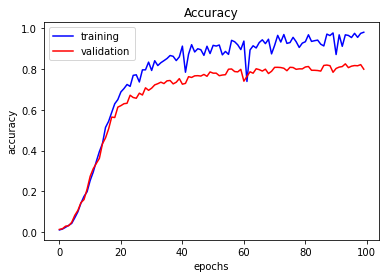

In [95]:
result_plot(t_value=t_acc,v_value=v_acc,title="Accuracy",min_point=None, ylabel="accuracy")

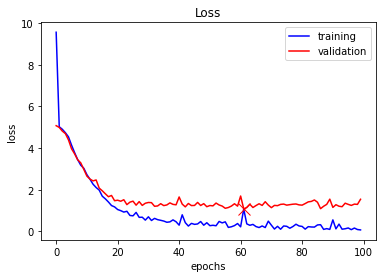

In [96]:
result_plot(t_value=t_loss,v_value=v_loss, title="Loss" ,min_point=(min_val_loss,min_val_loss_epoch), ylabel="loss")

In [97]:
min_val_loss_epoch.item()

1.0824387073516846

In [98]:
min_val_loss

61

In [99]:
v_acc[min_val_loss]

tensor(0.7643, device='cuda:0')

In [ ]:
v_loss[min_val_loss]